In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap lines
pd.set_option('display.expand_frame_repr', False)  # Don't break into multiple lines
pd.set_option('display.float_format', '{:.2f}'.format)


In [2]:
import os

# Define the directory name
directory_name = "final_models"

# Check if the directory exists, if not, create it
if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"Directory '{directory_name}' created.")
else:
    print(f"Directory '{directory_name}' already exists.")

Directory 'final_models' already exists.


## Read x_train and x_test

In [3]:
from joblib import dump, load
import os
import pandas as pd

load = ""
X_train = pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_X_train.csv')
X_test= pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_X_test.csv')
y_train = pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_y_train.csv')
y_test = pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_y_test.csv')

print(len(X_train), len(X_test), len(y_train), len(y_test))

18306 2937 18306 2937


## Function for evaluation

In [ ]:


def evaluate_model(model, X, y, label, raw_X, use_log=True):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
    import numpy as np
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()

    if hasattr(model, "predict"):
        y_pred = model.predict(X)
    elif hasattr(model, "predict_one"):
        y_pred = [model.predict_one(xi) for xi in X.to_dict(orient="records")]
    else:
        raise AttributeError("Model does not support predict or predict_one")

    if use_log:
        y = np.exp(y)
        y_pred = np.exp(y_pred)

    y_pred = np.array(y_pred)

    # Main line plot
    plt.figure(figsize=(14, 5))
    plt.plot(y.values, label="Actual", color='gold')
    plt.plot(y_pred, label="Predicted", color='limegreen', linestyle='--', alpha=0.4)
    plt.title("Aligned Predicted vs Actual Job Runtimes")
    plt.xlabel("Job Index")
    plt.ylabel("Runtime")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"\n----- {label} (All Jobs) -----")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Mean actual: {np.mean(y):.2f}")
    print("y shape:", y.shape)
    print("y_pred shape:", y_pred.shape)

    wallclock = raw_X['wallclock_req']
    # Conditions
    # --- Acceptance zone (runtime < predicted < wallclock)
    accepted = (y <= y_pred) & (y_pred < wallclock) 
    under = y_pred < y
    over = y_pred > wallclock  
    tolerance = 1e-6
    exact = (y_pred >= y) & (y_pred <= y + tolerance)
    negative = y_pred < 0

    # Percentages
    total = len(y)
    pct_accepted = 100 * accepted.sum() / total
    pct_under = 100 * under.sum() / total
    pct_over = 100 * over.sum() / total
    pct_exact = 100 * exact.sum() / total
    pct_negative = 100 * negative.sum() / total

    # Plot
    plt.figure(figsize=(9, 6))
    plt.scatter(y_pred[accepted], y[accepted], color='limegreen',
                label=f'Accepted ({pct_accepted:.1f}%)', alpha=0.7)
    plt.scatter(y_pred[under], y[under], color='red',
                label=f'Underestimated ({pct_under:.1f}%)', alpha=0.7)
    plt.scatter(y_pred[over], y[over], color='orange',
                label=f'Overestimated ({pct_over:.1f}%)', alpha=0.7)
    if exact.sum() > 0:
        plt.scatter(y_pred[exact], y[exact], color='blue', marker='x',
                    label=f'Exact Match ({pct_exact:.2f}%)', alpha=0.9)
    if negative.sum() > 0:
        plt.scatter(y_pred[negative], y[negative], color='black', marker='v',
                    label=f'Negative Prediction ({pct_negative:.2f}%)', alpha=0.9)

    # Decorations
    plt.xlabel("Predicted Runtime")
    plt.ylabel("Actual Runtime")
    plt.title("Prediction Zones")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Job length stats
    if 'job_length' in raw_X.columns:
        print("\n----- Per Job length Evaluation -----")
        for jl in sorted(raw_X['job_length'].unique()):
            idx = raw_X['job_length'] == jl
            print(f"\n[Job Length {jl}]")
            print(f"  R²: {r2_score(y[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_pred, y=y, hue=raw_X["job_length"], alpha=0.8)
        max_val = max(y.max(), y_pred.max())
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Predicted Runtime (log)")
        plt.ylabel("Actual Runtime (log)")
        plt.title("Predicted vs Actual by Job Length")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Job type stats
    if 'job_type' in raw_X.columns:
        print("\n----- Per Job type Evaluation -----")
        for jt in sorted(raw_X['job_type'].unique()):
            idx = raw_X['job_type'] == jt
            print(f"\n[Job Type {jt}]")
            print(f"  R²: {r2_score(y[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

    # Time-based plots
    raw_X = raw_X.copy()
    raw_X['submit_time'] = pd.to_datetime(raw_X['submit_time'], unit='s', errors='coerce')
    df_temp = pd.DataFrame({
        'submit_time': raw_X['submit_time'],
        'actual': y,
        'predicted': y_pred,
        'wallclock': wallclock
    })

    if 'x_test' in label.lower():
        df_temp['day'] = df_temp['submit_time'].dt.date
        for day, group in df_temp.groupby('day'):
            print(f"\n--- Day: {day} | Samples: {len(group)} ---")

            # Plot 1: MAE Line Plot
            abs_errors = np.abs(group['actual'] - group['predicted'])
            plt.figure(figsize=(8, 4))
            plt.plot(abs_errors.values, color='crimson')
            plt.title(f"Absolute Error per Job for {day}")
            plt.xlabel("Job Index")
            plt.ylabel("Absolute Error")
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Plot 2: Runtime Comparison (first 40)
            n = min(40, len(group))
            plt.figure(figsize=(10, 5))
            plt.plot(range(n), group['actual'].values[:n], label='Actual', marker='o', color='gold')
            plt.plot(range(n), group['predicted'].values[:n], label='Predicted', marker='s', linestyle='--', color='limegreen')
            plt.plot(range(n), group['wallclock'].values[:n], label='Wallclock', marker='^', linestyle=':', color='skyblue')
            plt.title(f"Runtime Comparison for {day} (First {n} Jobs)")
            plt.xlabel("Job Index")
            plt.ylabel("Runtime (seconds)")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.yscale('log')
            plt.show()

    else:
        df_temp['week'] = df_temp['submit_time'].dt.to_period('W').dt.start_time
        mae_over_time = []
        for week, group in df_temp.groupby('week'):
            mae = mean_absolute_error(group['actual'], group['predicted'])
            mae_over_time.append((week, mae))

        if mae_over_time:
            weeks, maes = zip(*mae_over_time)
            plt.figure(figsize=(10, 5))
            plt.plot(weeks, maes, marker='o', color='purple')
            plt.title("MAE over Time (Weekly)")
            plt.xlabel("Week")
            plt.ylabel("MAE")
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Final comparison of actual vs predicted vs wallclock (first 80)
        n = 80
        plt.figure(figsize=(12, 6))
        plt.plot(range(n), y[:n], label="Actual", color="gold", marker="o")
        plt.plot(range(n), y_pred[:n], label="Predicted", color="limegreen", linestyle="--", marker="s")
        plt.plot(range(n), df_temp['wallclock'][:n], label="Wallclock", color="skyblue", linestyle=":", marker="^")
        plt.title(f"Comparison of Actual, Predicted, and Wallclock Runtimes (First {n} Jobs)")
        plt.xlabel("Job Index")
        plt.ylabel("Runtime (seconds)")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.yscale('log')
        plt.show()

    # Negative predictions
    y_pred_series = pd.Series(y_pred, index=X.index)
    negative_idx = y_pred_series[y_pred_series < 0].index
    negative_features = X.loc[negative_idx].copy()
    negative_features['prediction'] = y_pred_series.loc[negative_idx]
    print(f"Number of negative predictions: {len(negative_features)}")
    print(negative_features.head())


## Find best hyperparameters for lasso

In [5]:
# from sklearn.linear_model import ElasticNetCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.compose import ColumnTransformer
# import numpy as np
# # In Lasso regression, the alpha parameter (often referred to as lambda in some contexts) 
# # controls the strength of the L1 regularization penalty. This penalty term is added to 
# # the ordinary least squares (OLS) objective function.

# # Time-aware cross-validation
# tscv = TimeSeriesSplit(n_splits=5)

# # Build pipeline
# lasso_pipeline = make_pipeline(
#     StandardScaler(),
#     ElasticNetCV(cv=tscv, 
#         l1_ratio = [0.001,0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
#         alphas = np.logspace(-20, -2, num=50), # 50 values from 1e-10 to 1e-2
#         max_iter=50000,  
#         selection='cyclic',
#         n_jobs=1   # safer for Jupyter
#     )
# )

# # You can also add verbose=1 to monitor progress
# lasso_pipeline.fit(X_train_final, y_train)

# # Extract the trained ElasticNetCV model
# lasso_cv_model = lasso_pipeline.named_steps['elasticnetcv']

# print(f"Best alpha: {lasso_cv_model.alpha_}")
# print(f"Best l1_ratio: {lasso_cv_model.l1_ratio_}")

## Extract only best features

In [ ]:
features_firt_approach = ['job_id', 'qos', 'gpus_req', 'user_account_name', 'processors_req_nodes',
'nodes_req_mem', 'processors_req_mem', 'partition_wallclock']

features_second_approach = ['partition_wallclock','cum_te_partition_qos','partition_qos_max_runtime_seen', 
'program_type_job_type_qos_partition_ratio_runtime_ema']

X_train_final = X_train[features_firt_approach]
X_test_final = X_test[features_firt_approach]

X_train_visu = X_train
X_test_visu = X_test

## Train Lasso Model

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# --- Time-aware CV ---
tscv = TimeSeriesSplit(n_splits=5)

lasso_pipeline = make_pipeline(
    StandardScaler(),
    LassoCV(cv=tscv),
)

# Train
lasso_pipeline.fit(X_train_final, y_train)
lasso_cv_model = lasso_pipeline.named_steps['lassocv']
print(f"Best alpha (via CV): {lasso_cv_model.alpha_}")

c:\Users\Soraya Khene\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha (via CV): 21.211072903492674


In [ ]:
# lasso_pipeline


Selected Features (coef ≠ 0):
['job_id', 'qos', 'gpus_req', 'user_account_name', 'processors_req_nodes', 'nodes_req_mem', 'processors_req_mem', 'partition_wallclock']


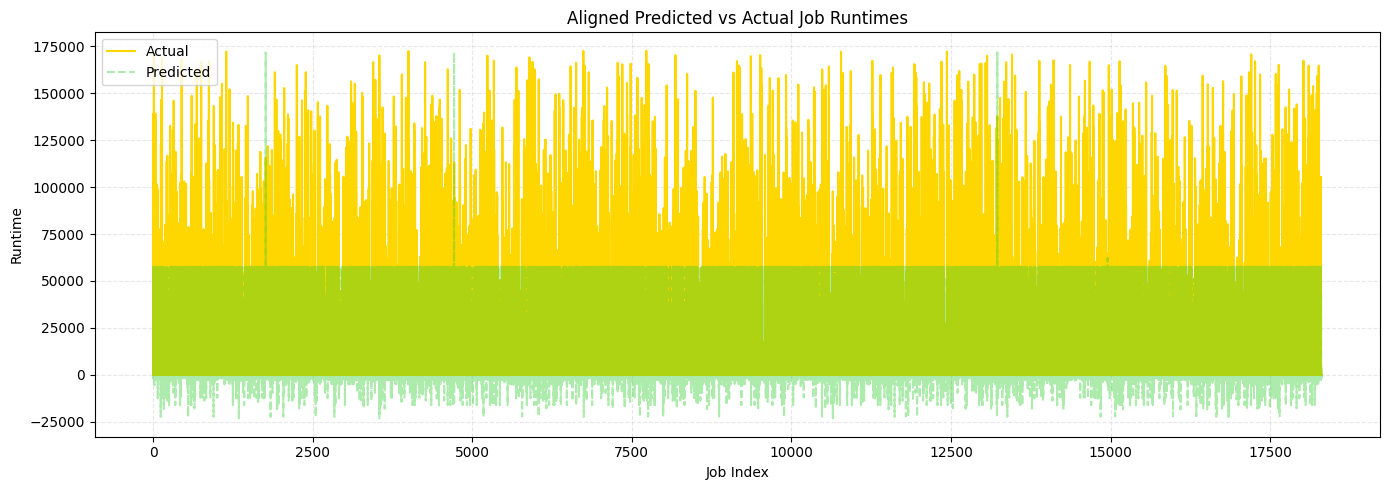


----- x_train (All Jobs) -----
R² Score: 0.493
MAE: 12254.17
RMSE: 22377.21
Mean actual: 13816.37
y shape: (18306,)
y_pred shape: (18306,)


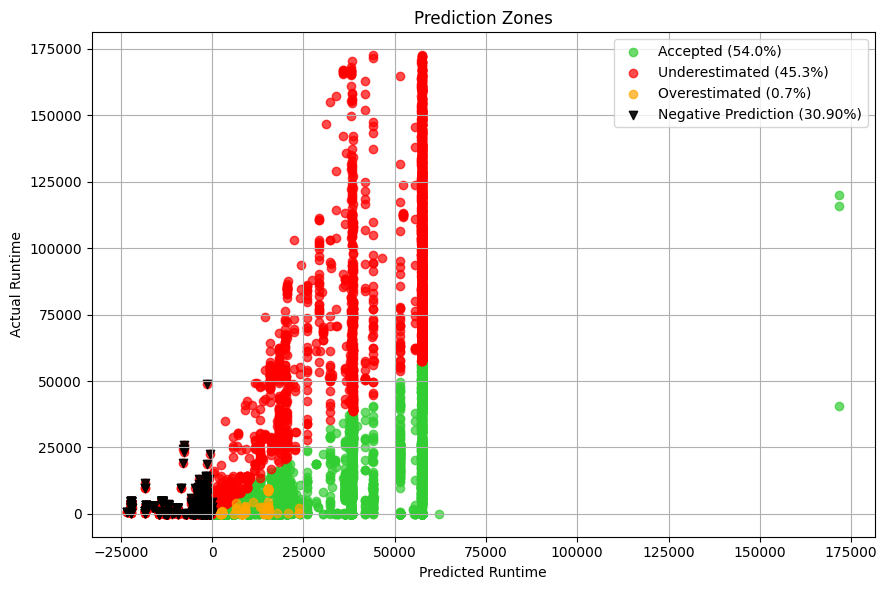


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.308
  MAE: 26211.87
  RMSE: 35772.33
  Samples: 5415

[Job Length medium]
  R²: -473.734
  MAE: 7015.77
  RMSE: 11159.52
  Samples: 1375

[Job Length short]
  R²: -12321.663
  MAE: 6316.51
  RMSE: 13393.96
  Samples: 11516


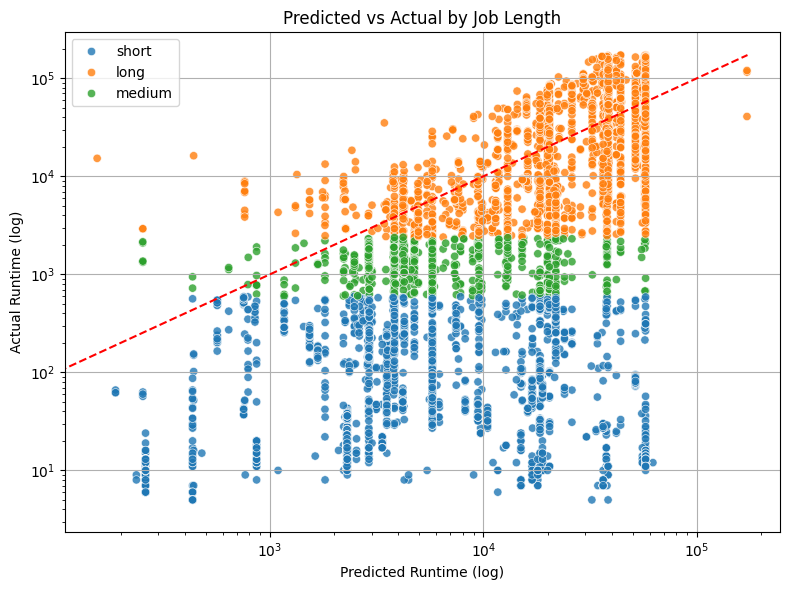


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: 0.196
  MAE: 19568.99
  RMSE: 31788.72
  Samples: 904

[Job Type distributed_gpu]
  R²: -3.134
  MAE: 11708.60
  RMSE: 14162.65
  Samples: 35

[Job Type multithreaded]
  R²: 0.414
  MAE: 24500.70
  RMSE: 34679.88
  Samples: 5085

[Job Type serial]
  R²: 0.288
  MAE: 6672.56
  RMSE: 13191.18
  Samples: 11854

[Job Type single_node_gpu]
  R²: 0.529
  MAE: 5939.50
  RMSE: 12569.93
  Samples: 428


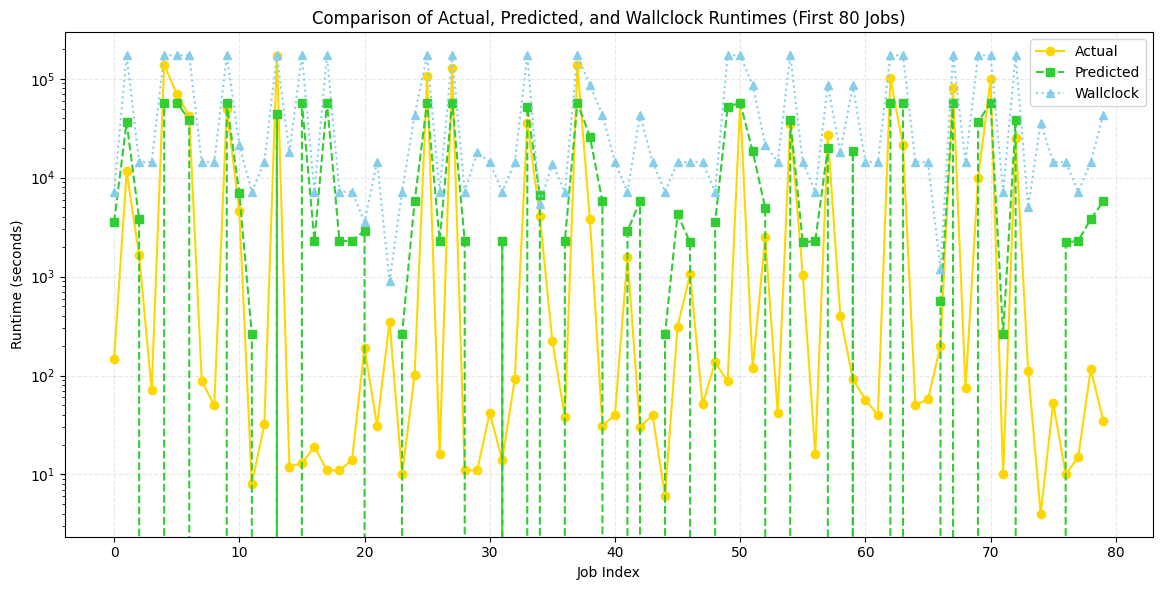

Number of negative predictions: 5656
      job_id  qos  gpus_req  user_account_name  processors_req_nodes  nodes_req_mem  processors_req_mem  partition_wallclock  prediction
3   11440393   20         0                  0                  1.00       85248.00            85248.00            432000.00    -1767.02
7   11537711   20         0                  2                 36.00       85248.00             2368.00            432000.00     -687.22
8   11534191   20         0                  0                  1.00       85248.00            85248.00            432000.00    -1750.46
12  11414851   20         0                  0                  1.00       85248.00            85248.00            432000.00    -1771.53
14  11647009   25         0                  4                  1.00       85248.00            85248.00            900000.00    -2792.53


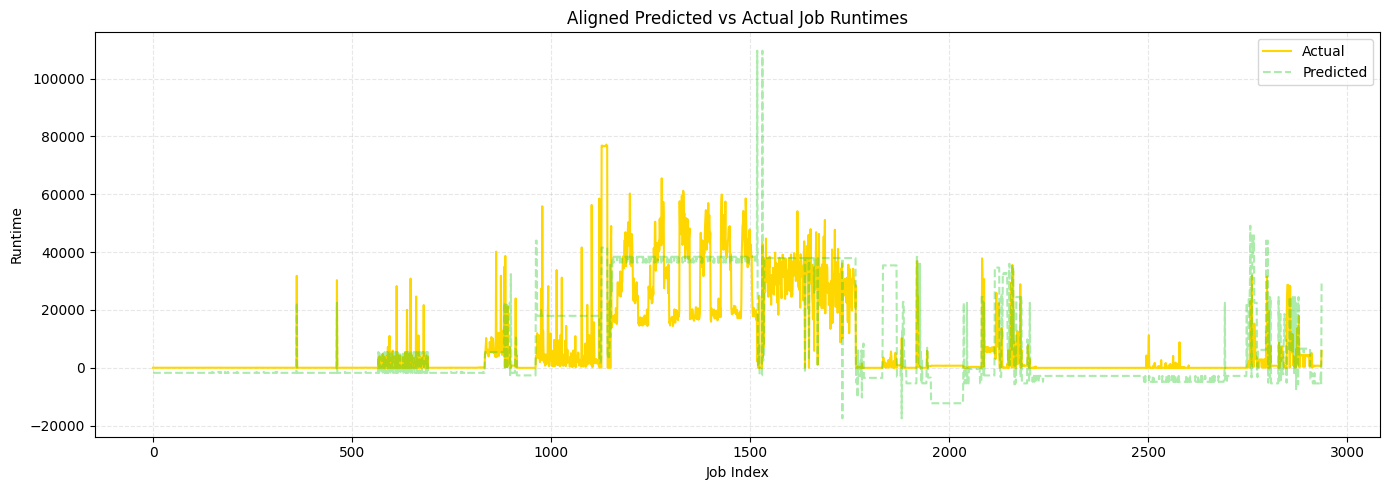


----- x_test (All Jobs) -----
R² Score: 0.452
MAE: 7094.78
RMSE: 10714.37
Mean actual: 8000.30
y shape: (2937,)
y_pred shape: (2937,)


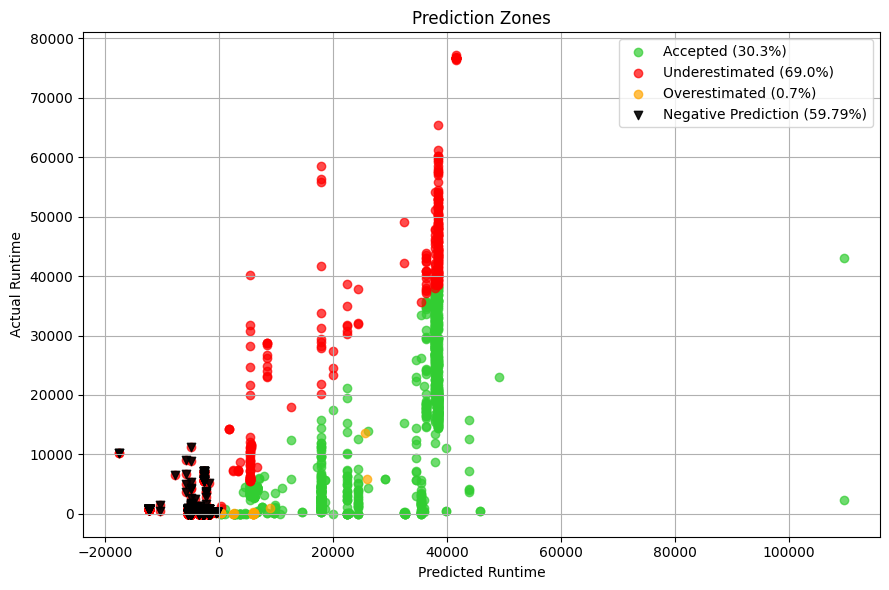


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.240
  MAE: 11405.87
  RMSE: 14267.48
  Samples: 1000

[Job Length medium]
  R²: -1062.517
  MAE: 12647.38
  RMSE: 15696.82
  Samples: 274

[Job Length short]
  R²: -4810.038
  MAE: 3587.56
  RMSE: 6304.04
  Samples: 1663


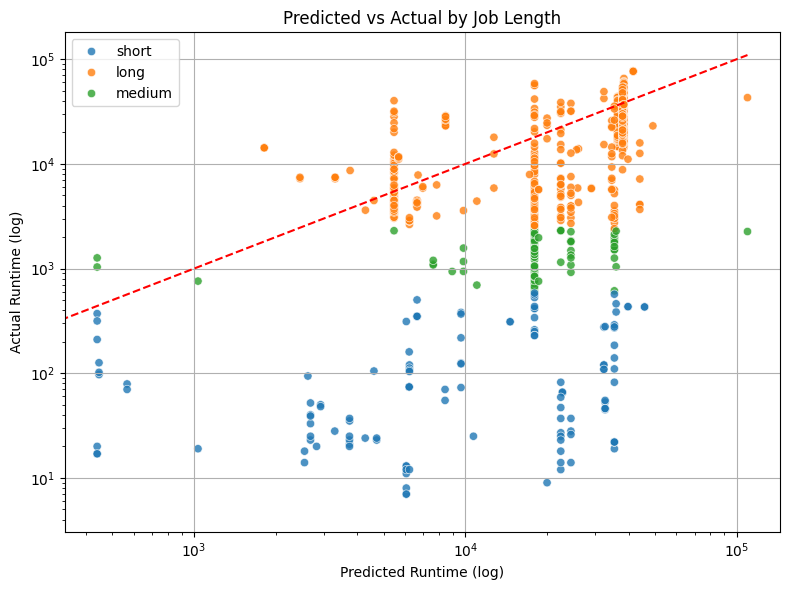


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: -5.252
  MAE: 15759.23
  RMSE: 18717.56
  Samples: 117

[Job Type distributed_gpu]
  R²: -23.820
  MAE: 15463.90
  RMSE: 16867.23
  Samples: 9

[Job Type multithreaded]
  R²: 0.213
  MAE: 12684.95
  RMSE: 15859.06
  Samples: 516

[Job Type serial]
  R²: 0.564
  MAE: 5332.83
  RMSE: 8470.74
  Samples: 2235

[Job Type single_node_gpu]
  R²: -2.494
  MAE: 6500.67
  RMSE: 7596.24
  Samples: 60
Number of negative predictions: 1756
     job_id  qos  gpus_req  user_account_name  processors_req_nodes  nodes_req_mem  processors_req_mem  partition_wallclock  prediction
0  11670836   20         0                  0                  1.00       85248.00            85248.00            432000.00    -1726.34
1  11670839   20         0                  0                  1.00       85248.00            85248.00            432000.00    -1726.34
2  11670825   20         0                  0                  1.00       85248.00            8

In [10]:
trained_features = X_train_final.columns
# evaluate_model(lasso_pipeline, X_train_final, y_train, "Before Feature Selection (LassoCV) - Train", X_train_visu)
X_test_final = X_test_final[trained_features]
# evaluate_model(lasso_pipeline,X_test_final, y_test, "Before Feature Selection (LassoCV) - Test", X_test_visu)

# --- Feature Selection ---
selected_features = X_train_final.columns[lasso_cv_model.coef_ != 0]
print("\nSelected Features (coef ≠ 0):")
print(selected_features.tolist())

X_train_selected = X_train_final[selected_features]
X_test_selected =X_test_final[selected_features]

# --- Final model with selected features ---
final_model = make_pipeline(
    StandardScaler(),
    Lasso(alpha=lasso_cv_model.alpha_, max_iter=10000, tol=1e-4)
)
# Use this alpha value (found via CV), be deterministic, allow up to 1000 iterations, 
# and stop if changes are smaller than 1e-4
final_model.fit(X_train_selected, y_train)

# --- Final evaluation ---
evaluate_model(final_model, X_train_selected, y_train, "x_train", X_train_visu, False)
evaluate_model(final_model, X_test_selected, y_test, "x_test", X_test_visu, False)

## Extract feature importance

In [ ]:
import pandas as pd
import numpy as np

# `lasso_model` is the trained Lasso model
coef = lasso_cv_model.coef_
features = X_train_final.columns

lasso_df = pd.DataFrame({'feature': features, 'coefficient': coef})
lasso_df['abs_coef'] = np.abs(lasso_df['coefficient'])
# Top 10 features by absolute coefficient value
top_lasso_features_list = lasso_df.sort_values(by='abs_coef', ascending=False).head(10)['feature'].tolist()
print(top_lasso_features_list)

['partition_wallclock', 'cum_te_partition_qos', 'partition_qos_max_runtime_seen', 'program_type_job_type_qos_partition_ratio_runtime_ema']


### download

In [ ]:
# import joblib

# # Save the model
# joblib.dump(final_model, f'final_models/lasso_minimal_features.pkl')

### upload for prediction

In [ ]:
# import joblib

# loaded_lasso = joblib.load('final_models/lasso_minimal_features.pkl')
# predictions = loaded_lasso.predict(X_test_final[selected_features])
# predictions

## Find best hyperparameters for XGBOOST

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
# from sklearn.preprocessing import FunctionTransformer
# import xgboost as xgb
# import numpy as np
# import pandas as pd

# # -------------------------------
# # 0. Custom Scorer: RMSE in log space
# # -------------------------------
# rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# # -------------------------------
# # 2. Define Hyperparameter Space
# # -------------------------------
# param_dist = {
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'min_child_weight': [2, 3, 4],
#     'reg_alpha': [1, 5, 10],
#     'reg_lambda': [5, 10, 15],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.6, 0.7, 0.8],
#     'n_estimators': [100, 200, 300],
# }

# # -------------------------------
# # 3. Base Model
# # -------------------------------
# xgb_base = xgb.XGBRegressor(
#     random_state=42,
#     objective="reg:squarederror",
#     tree_method="hist",
#     n_jobs=-1
# )

# # -------------------------------
# # 4. Cross-Validation
# # -------------------------------
# cv = TimeSeriesSplit(n_splits=5)

# # -------------------------------
# # 5. Randomized Search
# # -------------------------------
# random_search = RandomizedSearchCV(
#     estimator=xgb_base,
#     param_distributions=param_dist,
#     n_iter=60,
#     scoring=rmse_scorer,  # RMSE in log space
#     cv=cv,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# # -------------------------------
# # 6. Fit the Search on log target
# # -------------------------------
# random_search.fit(X_train_final[selected_features], y_train)

# # -------------------------------
# # 7. Best Estimator and Final Fit
# # -------------------------------
# best_xgb_model = random_search.best_estimator_
# best_xgb_model.fit(X_train_final[selected_features], y_train)

# # -------------------------------
# # 8. Evaluation Function


# # -------------------------------
# # 9. Final Evaluation
# # -------------------------------
# evaluate_model(best_xgb_model, X_train_final[selected_features], y_train, "Train", X_train_visu)
# evaluate_model(best_xgb_model, X_test_final[selected_features], y_test, "Test", X_test_visu)


## Train XGBOOST Regressor

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Best XGBoost parameters (from tuning)
best_params = {
    'subsample': 0.8,
    'reg_lambda': 10, #  L2 regularization.
    'reg_alpha': 5, #  L1 regularization term
    'n_estimators': 30,
    'min_child_weight': 3,
    'max_depth': 2,
    'learning_rate': 0.1,
    'colsample_bytree': 0.6,
    'objective': 'reg:squarederror',
    'random_state': 42
}

features_firt_approach = ['job_id', 'qos', 'gpus_req', 'user_account_name', 'processors_req_nodes',
'nodes_req_mem', 'processors_req_mem', 'partition_wallclock']
features_second_approach = ['partition_wallclock', 'program_type_job_type_qos_partition_ratio_runtime_ema', 'program_type_job_type_wallclock_avg_runtime_seen', 'processors_req_mem']

# 3. Ensure target is 1D
y_train_ = y_train.values.ravel() if hasattr(y_train, 'values') else np.ravel(y_train)
y_test_ = y_test.values.ravel() if hasattr(y_test, 'values') else np.ravel(y_test)

# 4. Train the model
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train[features_firt_approach], y_train_)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=30,
             n_jobs=None, num_parallel_tree=None, ...)

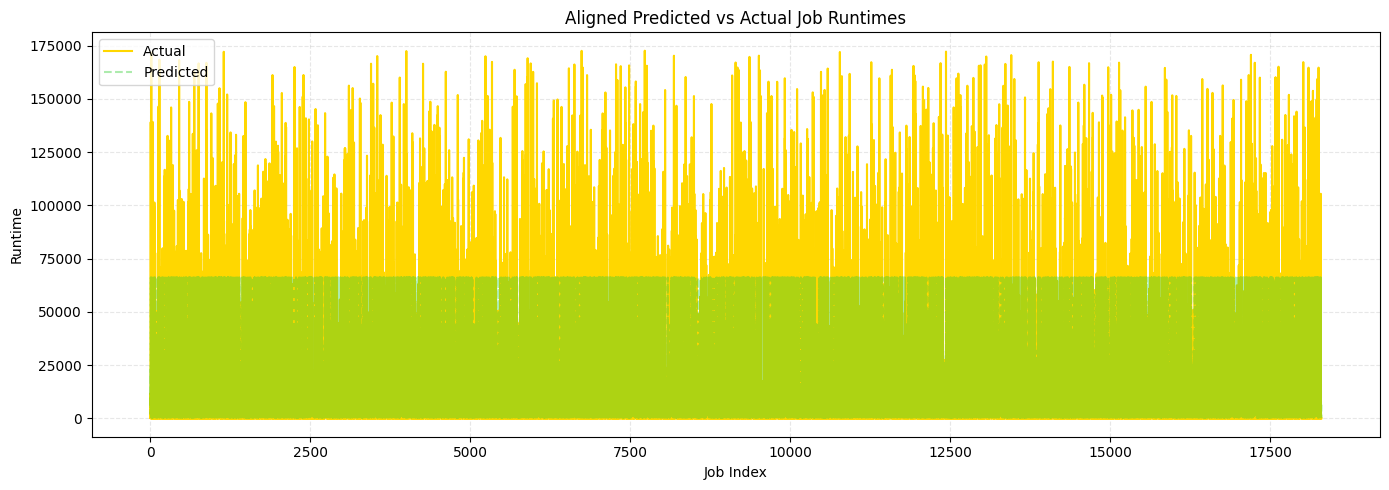


----- x_train (All Jobs) -----
R² Score: 0.562
MAE: 10189.23
RMSE: 20801.64
Mean actual: 13816.37
y shape: (18306,)
y_pred shape: (18306,)


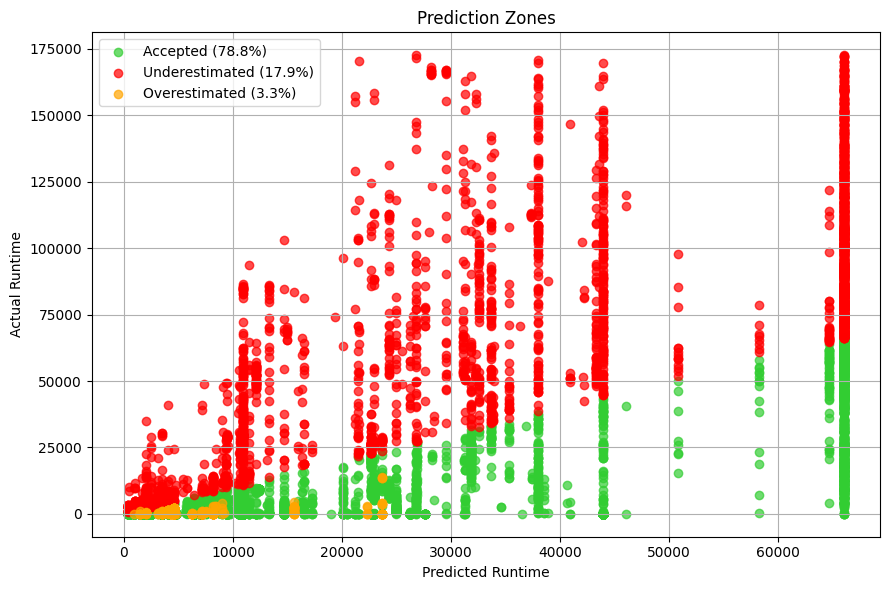


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.320
  MAE: 23930.99
  RMSE: 35458.36
  Samples: 5415

[Job Length medium]
  R²: -201.242
  MAE: 4496.26
  RMSE: 7283.76
  Samples: 1375

[Job Length short]
  R²: -6201.952
  MAE: 4407.38
  RMSE: 9502.90
  Samples: 11516


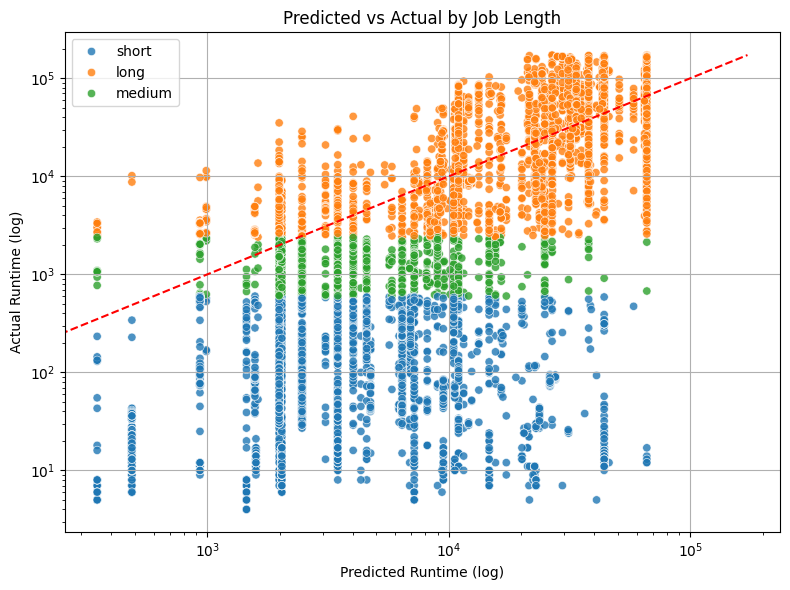


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: 0.150
  MAE: 18131.03
  RMSE: 32683.32
  Samples: 904

[Job Type distributed_gpu]
  R²: -8.351
  MAE: 18774.19
  RMSE: 21300.96
  Samples: 35

[Job Type multithreaded]
  R²: 0.492
  MAE: 21768.12
  RMSE: 32288.45
  Samples: 5085

[Job Type serial]
  R²: 0.465
  MAE: 4670.21
  RMSE: 11435.42
  Samples: 11854

[Job Type single_node_gpu]
  R²: 0.386
  MAE: 8002.33
  RMSE: 14351.43
  Samples: 428


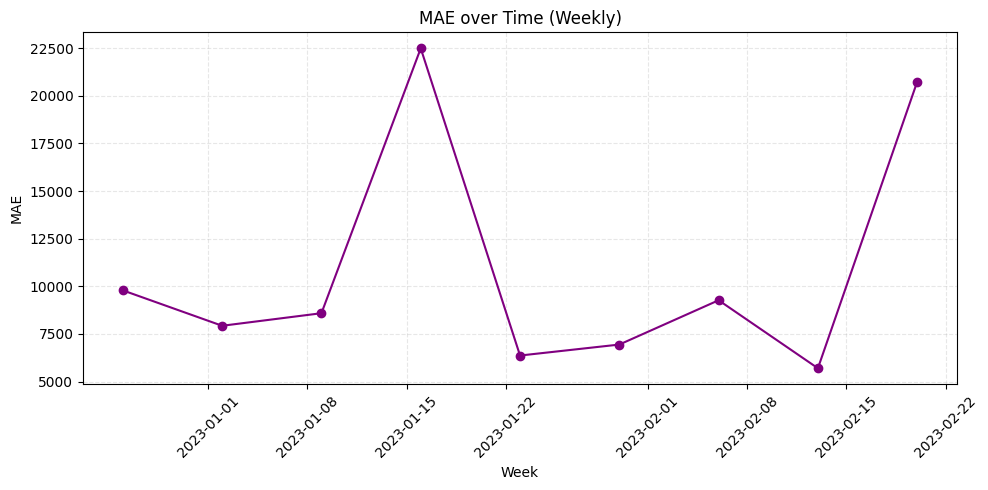

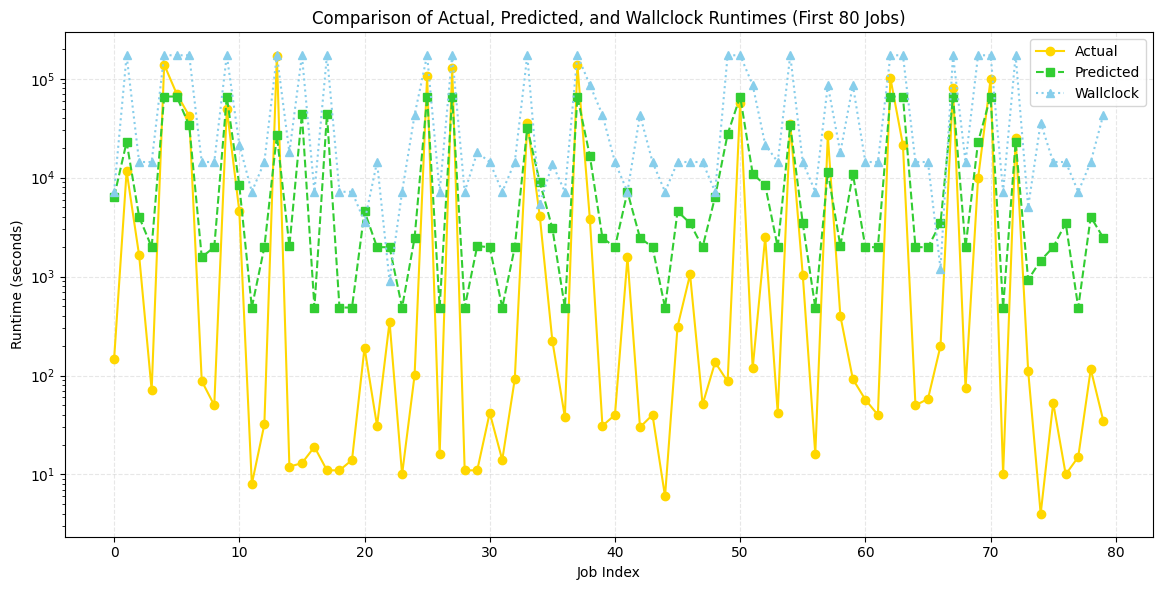

Number of negative predictions: 0
Empty DataFrame
Columns: [job_id, qos, gpus_req, user_account_name, processors_req_nodes, nodes_req_mem, processors_req_mem, partition_wallclock, prediction]
Index: []


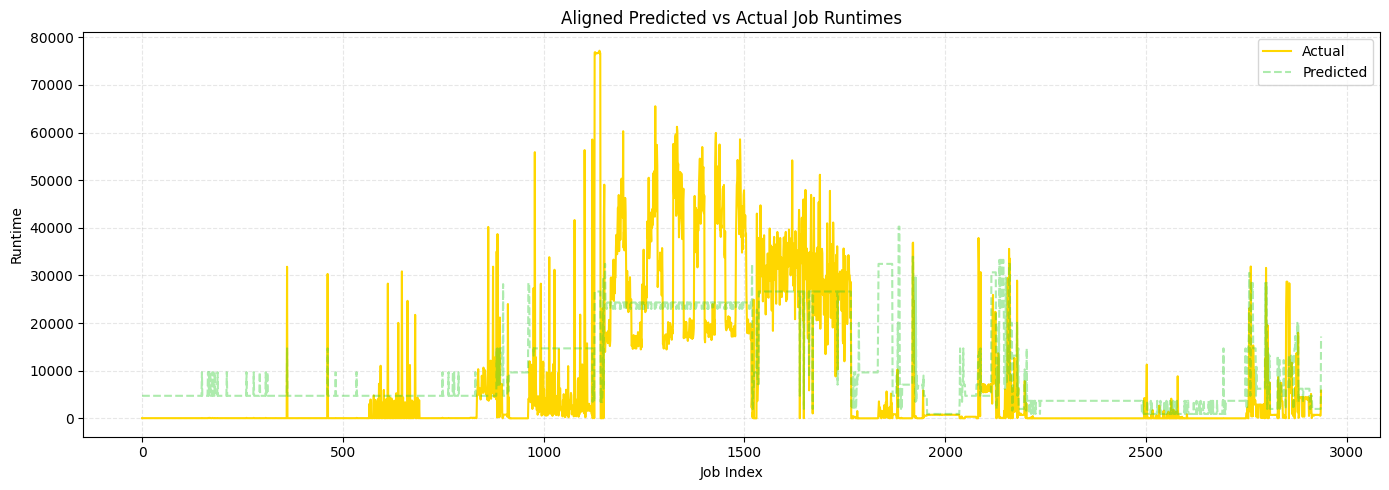


----- x_test (All Jobs) -----
R² Score: 0.523
MAE: 6877.79
RMSE: 9995.52
Mean actual: 8000.30
y shape: (2937,)
y_pred shape: (2937,)


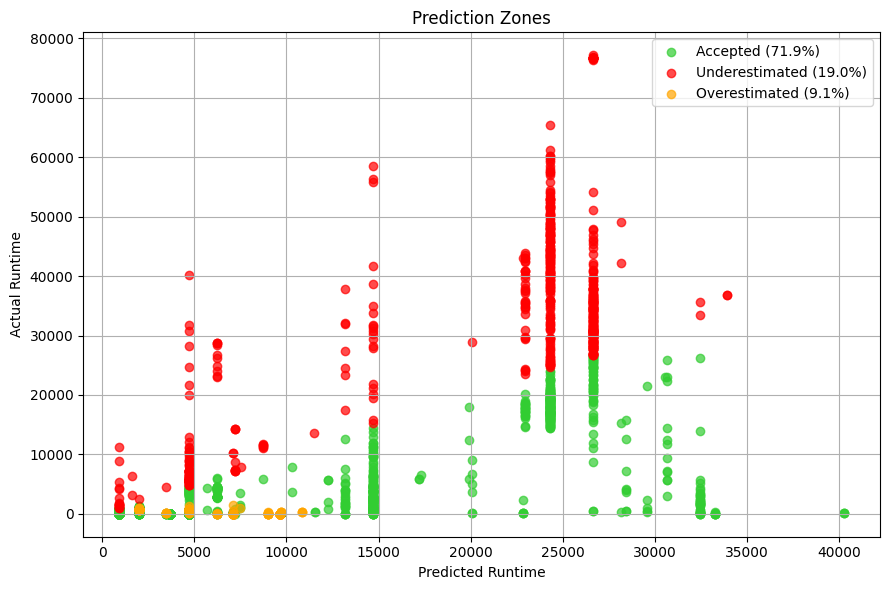


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.303
  MAE: 9788.05
  RMSE: 13657.08
  Samples: 1000

[Job Length medium]
  R²: -414.881
  MAE: 5766.80
  RMSE: 9815.76
  Samples: 274

[Job Length short]
  R²: -5860.651
  MAE: 5310.83
  RMSE: 6958.41
  Samples: 1663


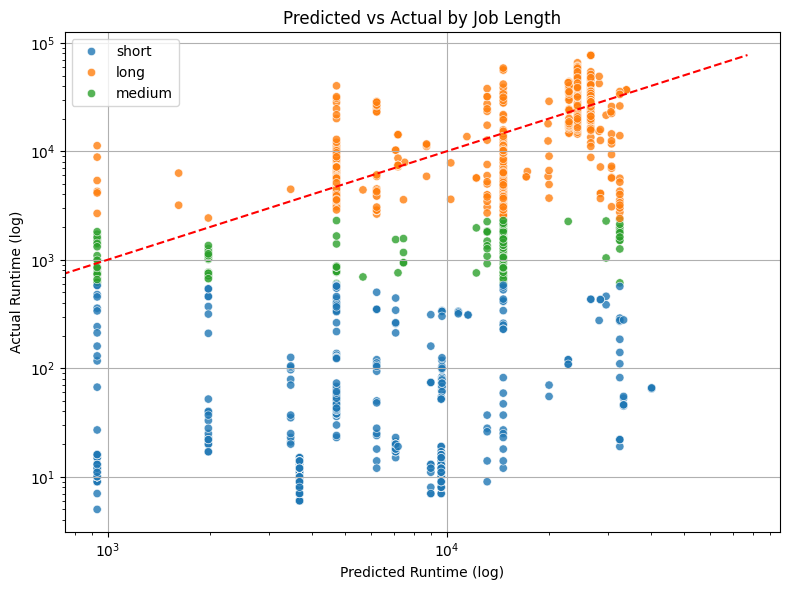


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: -1.367
  MAE: 9605.01
  RMSE: 11517.99
  Samples: 117

[Job Type distributed_gpu]
  R²: -8.769
  MAE: 9465.82
  RMSE: 10582.00
  Samples: 9

[Job Type multithreaded]
  R²: 0.269
  MAE: 11062.89
  RMSE: 15277.29
  Samples: 516

[Job Type serial]
  R²: 0.597
  MAE: 5698.90
  RMSE: 8140.56
  Samples: 2235

[Job Type single_node_gpu]
  R²: -7.441
  MAE: 9092.99
  RMSE: 11807.50
  Samples: 60

--- Day: 2023-02-20 | Samples: 1519 ---


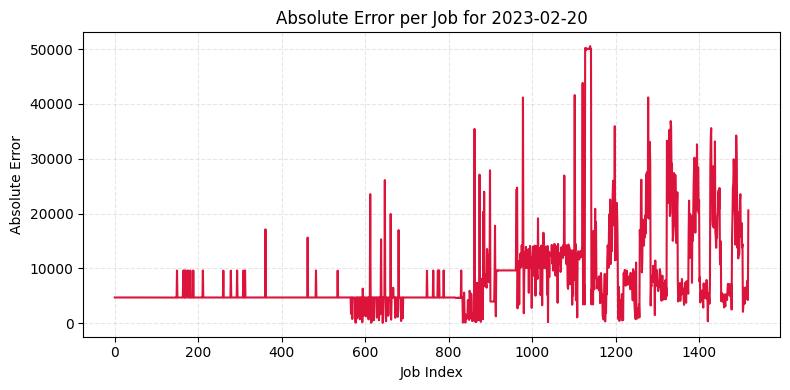

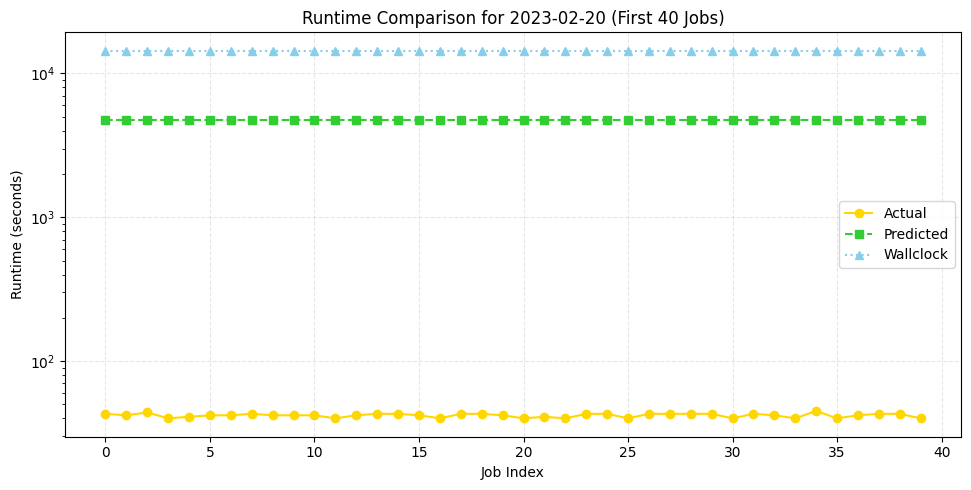


--- Day: 2023-02-21 | Samples: 1418 ---


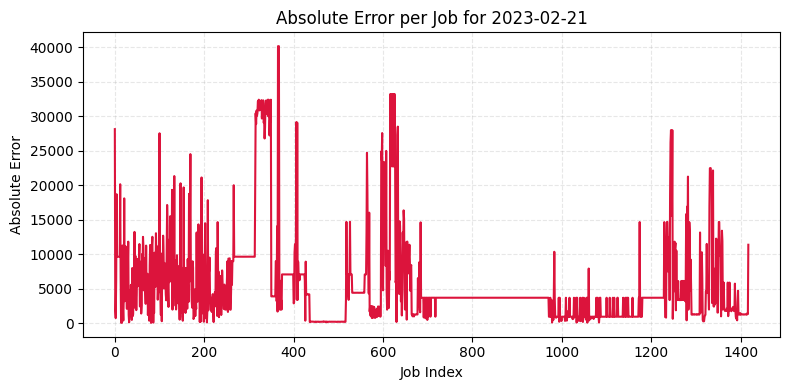

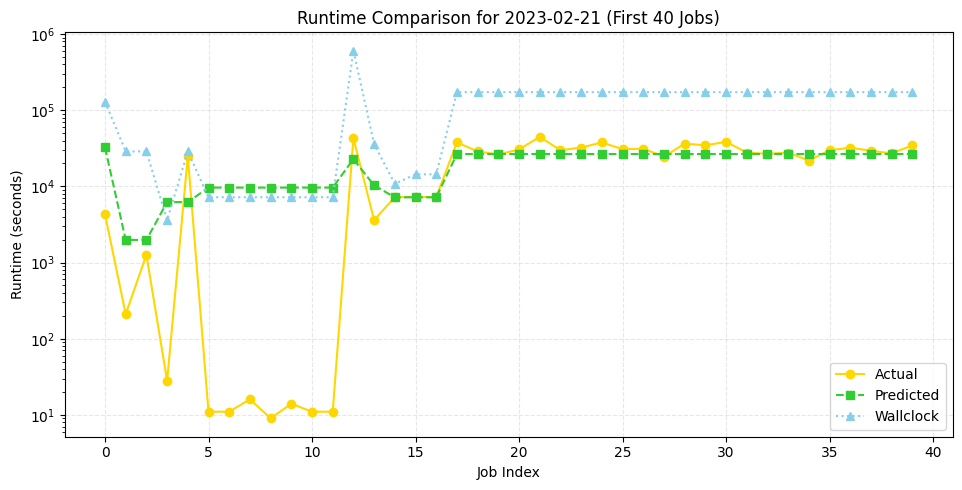

Number of negative predictions: 0
Empty DataFrame
Columns: [job_id, qos, gpus_req, user_account_name, processors_req_nodes, nodes_req_mem, processors_req_mem, partition_wallclock, prediction]
Index: []


In [ ]:
# # Evaluate
evaluate_model(xgb_model,X_train[features_firt_approach], y_train, "x_train", X_train_visu, False)
evaluate_model(xgb_model,X_test[features_firt_approach], y_test, "x_test", X_test_visu,False) 

In [ ]:
for importance_type in ['weight', 'gain', 'cover']:
    scores = xgb_model.get_booster().get_score(importance_type=importance_type)
    print(f"\nTop features by {importance_type}:")
    print(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10])
        # Sort features by importance (descending), keep only the names
    top_features = [feat for feat, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]]
    print(top_features)



Top features by weight:
[('program_type_job_type_wallclock_avg_runtime_seen', 31.0), ('partition_wallclock', 26.0), ('program_type_job_type_qos_partition_ratio_runtime_ema', 20.0), ('processors_req_mem', 13.0)]
['program_type_job_type_wallclock_avg_runtime_seen', 'partition_wallclock', 'program_type_job_type_qos_partition_ratio_runtime_ema', 'processors_req_mem']

Top features by gain:
[('processors_req_mem', 560627187712.0), ('program_type_job_type_wallclock_avg_runtime_seen', 544057491456.0), ('partition_wallclock', 528843407360.0), ('program_type_job_type_qos_partition_ratio_runtime_ema', 463575285760.0)]
['processors_req_mem', 'program_type_job_type_wallclock_avg_runtime_seen', 'partition_wallclock', 'program_type_job_type_qos_partition_ratio_runtime_ema']

Top features by cover:
[('partition_wallclock', 11892.26953125), ('processors_req_mem', 10217.76953125), ('program_type_job_type_qos_partition_ratio_runtime_ema', 8665.5), ('program_type_job_type_wallclock_avg_runtime_seen', 84

## Greedy search Lasso

In [ ]:
# from sklearn.linear_model import LassoCV
# from sklearn.metrics import mean_absolute_error
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import TimeSeriesSplit
# from itertools import combinations
# import numpy as np
# import random

# # Feature list (customized by you)
# # f = [
# #     'partition_wallclock', 'partition_qos_ratio_runtime_ema',
# #     'program_type_job_type_qos_partition_avg_runtime_seen',
# #     'cum_te_program_type_job_type_qos_partition', 'cum_te_partition_qos',
# #     'partition_qos_max_runtime_seen', 'program_type_job_type_qos_partition_ratio_runtime_ema',
# #     'program_type_job_type_wallclock_avg_runtime_seen', 'processors_req_mem',
# #     'job_type_id_ratio_runtime_ema'
# # ]

# # Limit number of features for combinatorial search
# max_features = 10
# if len(f) > max_features:
#     all_features = random.sample(f, max_features)
# else:
#     all_features = f

# best_combination = None
# best_score = float('inf')

# # Time-aware CV
# tscv = TimeSeriesSplit(n_splits=5)

# print("Starting exhaustive feature combination search with Lasso (TimeSeriesSplit):")

# # Ensure y is 1D
# y_train_ = y_train.values.ravel() if hasattr(y_train, 'values') else np.ravel(y_train)
# y_test_ = y_test.values.ravel() if hasattr(y_test, 'values') else np.ravel(y_test)

# # Search all combinations
# for k in range(1, len(all_features) + 1):
#     for subset in combinations(all_features, k):
#         subset = list(subset)
#         X_train_subset = X_train_final[subset]
#         X_test_subset = X_test_final[subset]

#         # Lasso pipeline with TimeSeriesSplit
#         model = make_pipeline(
#             StandardScaler(),
#             LassoCV(cv=tscv, random_state=42, max_iter=10000)
#         )

#         model.fit(X_train_subset, y_train_)
#         preds = model.predict(X_test_subset)
#         mae = mean_absolute_error(y_test_, preds)

#         if mae < best_score:
#             best_score = mae
#             best_combination = subset
#             print(f"New best subset: {subset} → MAE: {mae:.4f}")

# print("\nSearch complete.")
# print(f"Best feature combination: {best_combination}")
# print(f"Best MAE: {best_score:.4f}")


## Greedy search XGBoost

In [ ]:
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error
# from itertools import combinations
# import numpy as np
# import random

# # Feature list (customized by you from Lasso example)
# f = [
#     'partition_wallclock', 'partition_qos_ratio_runtime_ema',
#     'program_type_job_type_qos_partition_avg_runtime_seen',
#     'cum_te_program_type_job_type_qos_partition', 'cum_te_partition_qos',
#     'partition_qos_max_runtime_seen', 'program_type_job_type_qos_partition_ratio_runtime_ema',
#     'program_type_job_type_wallclock_avg_runtime_seen', 'processors_req_mem',
#     'job_type_id_ratio_runtime_ema'
# ]

# # Limit number of features for combinatorial search
# max_features = 10
# if len(f) > max_features:
#     all_features = random.sample(f, max_features)
# else:
#     all_features = f

# # Best parameters for XGBoost (using parameters from previous XGBoost example)
# best_params = {
#     'subsample': 0.8,
#     'reg_lambda': 10,
#     'reg_alpha': 5,
#     'n_estimators': 100,
#     'min_child_weight': 3,
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'colsample_bytree': 0.6,
#     'objective': 'reg:squarederror',
#     'random_state': 42
# }

# best_combination = None
# best_score = float('inf')

# print("Starting exhaustive feature combination search with XGBoost (evaluating on test set):")

# # Ensure y is 1D
# y_train_ = y_train.values.ravel() if hasattr(y_train, 'values') else np.ravel(y_train)
# y_test_ = y_test.values.ravel() if hasattr(y_test, 'values') else np.ravel(y_test)

# # Search all combinations
# for k in range(1, len(all_features) + 1):
#     for subset in combinations(all_features, k):
#         subset = list(subset)
#         X_train_subset = X_train_final[subset]
#         X_test_subset = X_test_final[subset]

#         # XGBoost model
#         model = XGBRegressor(**best_params, verbosity=0)

#         # Train on the entire training set
#         model.fit(X_train_subset, y_train_)

#         # Predict on the entire test set
#         preds = model.predict(X_test_subset)
#         mae = mean_absolute_error(y_test_, preds)

#         if mae < best_score:
#             best_score = mae
#             best_combination = subset
#             print(f"New best subset: {subset} → MAE (Test): {mae:.4f}")

# print("\nSearch complete.")
# print(f"Best feature combination: {best_combination}")
# print(f"Best MAE (Test): {best_score:.4f}")

In [ ]:
# joblib.dump(xgb_model, f'final_models/xgboost_minimal_features.pkl')